In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns
from datasets import Dataset, DatasetDict
# from modality.contig_dataset import ContigDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

from methformer import MethformerDataset

# 📊 Dataset

In [2]:
# def tile_regions(regions_df, tile_size=32):
#     tiled_rows = []

#     for _, row in regions_df.iterrows():
#         chrom = row["Chromosome"]
#         start = row["Start"]
#         name = row["Name"]
#         score = row.get("Score", ".")
#         strand = row.get("Strand", ".")

#         for i in range(0, 1024, tile_size):
#             tiled_rows.append(
#                 {
#                     "Chromosome": chrom,
#                     "Start": start + i,
#                     "End": start + i + tile_size,
#                     "RegionName": name,
#                     "Bin": i // tile_size,
#                     "Score": score,
#                     "Strand": strand,
#                 }
#             )

#     tiled_df = pd.DataFrame(tiled_rows)
#     return pr.PyRanges(tiled_df)

# regions = pr.read_bed("data/regions/methylome_1024bp.bed", as_df=True)
# binned_regions = tile_regions(regions, tile_size=32)

# meth_ds = ContigDataset.from_zarrz(
#     "data/meth_evoc.targeted.GRCh38Decoy.markdup.CG.zarrz"
# )

# meth_ds.assign_fractions(
#     numerators=["num_mc", "num_hmc", "num_modc"],
#     denominator="num_total_c",
#     min_coverage=5,
#     inplace=True,
# )

# meth_panel_ds = meth_ds.reduce_byranges(
#     ranges=binned_regions, 
#     ranges_are_1based=False, 
#     var=["frac_mc", "frac_hmc"]
# )

# df = meth_panel_ds.to_dataframe().reset_index()

# # Filter out xenograft samples
# df = df[~df["sample_id"].str.contains("xeno")]
# df = df[["RegionName", "Bin", "sample_id", "frac_mc_mean", "frac_hmc_mean", "contig", "start"]]
# df[["frac_mc_mean", "frac_hmc_mean"]] = df[["frac_mc_mean", "frac_hmc_mean"]].fillna(-1).astype(np.float32)

# df.to_parquet("data/meth_panel_binned.parquet", index=False)

df = pd.read_parquet("data/meth_panel_binned.parquet")

In [3]:
# Pivot to get (RegionName, Bin) × sample matrices for each methylation type
mc_df = df.pivot(index=["RegionName", "Bin"], columns="sample_id", values="frac_mc_mean")
hmc_df = df.pivot(index=["RegionName", "Bin"], columns="sample_id", values="frac_hmc_mean")
print(mc_df.shape, hmc_df.shape)

# Drop only regions where all bins are -1 across both mc and hmc
region_mask = (
    (mc_df != -1).groupby("RegionName").any().any(axis=1) |
    (hmc_df != -1).groupby("RegionName").any().any(axis=1)
)
# Get valid regions where at least one bin has a valid value
valid_regions = region_mask[region_mask].index

# Filter to retain only valid regions (even if some bins are -1)
mc_df = mc_df.loc[mc_df.index.get_level_values("RegionName").isin(valid_regions)]
hmc_df = hmc_df.loc[hmc_df.index.get_level_values("RegionName").isin(valid_regions)]

# Sort for consistent reshaping later
mc_df = mc_df.sort_index(level=["RegionName", "Bin"])
hmc_df = hmc_df.sort_index(level=["RegionName", "Bin"])

# Final check
print(mc_df.shape, hmc_df.shape)


(16492800, 10) (16492800, 10)
(15989952, 10) (15989952, 10)


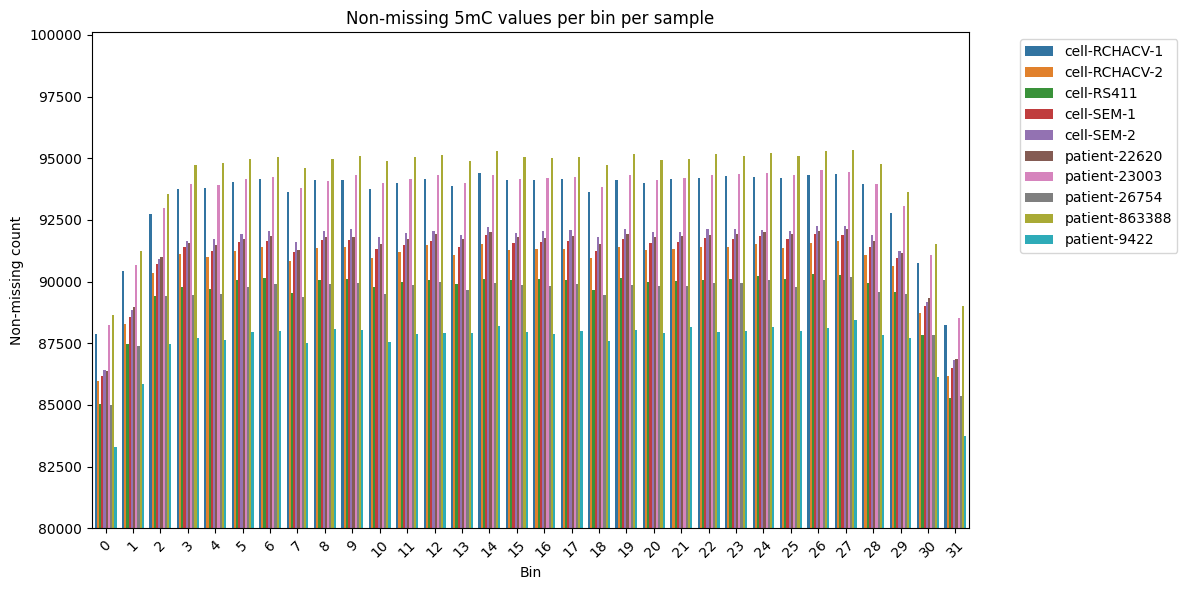

In [4]:
non_missing_per_bin = (
    mc_df != -1
).groupby(level="Bin").sum()


# Reset index for plotting
plot_df = non_missing_per_bin.reset_index().melt(id_vars="Bin", var_name="Sample", value_name="Count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Bin", y="Count", hue="Sample")
plt.title("Non-missing 5mC values per bin per sample")
plt.ylabel("Non-missing count")
plt.xlabel("Bin")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim(80_000, None) 
plt.show()

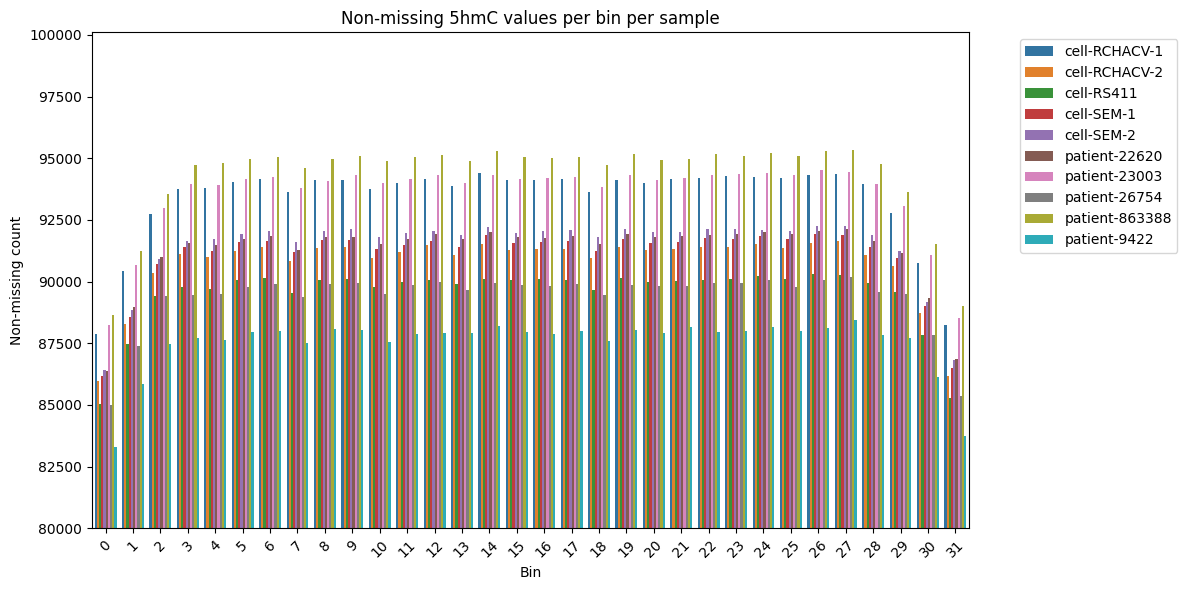

In [5]:
non_missing_per_bin = (
    hmc_df != -1
).groupby(level="Bin").sum()


# Reset index for plotting
plot_df = non_missing_per_bin.reset_index().melt(id_vars="Bin", var_name="Sample", value_name="Count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Bin", y="Count", hue="Sample")
plt.title("Non-missing 5hmC values per bin per sample")
plt.ylabel("Non-missing count")
plt.xlabel("Bin")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim(80_000, None) 
plt.show()

In [6]:
# Stack and reshape
mc_arr = mc_df.values  # shape: (regions * 32, samples)
hmc_arr = hmc_df.values

# Combine → shape: (regions * 32, samples, 2)
meth_arr = np.stack([mc_arr, hmc_arr], axis=-1)
meth_arr[np.isnan(meth_arr)] = -1.0

n_total_rows = mc_df.shape[0]
n_bins = 32
n_samples = mc_df.shape[1]
n_regions = n_total_rows // n_bins
print(
    f"Total rows: {n_total_rows}, Regions: {n_regions}, Bins: {n_bins}, Samples: {n_samples}"
)
assert n_total_rows == n_regions * n_bins, (
    "Unexpected number of rows — incomplete regions exist"
)


Total rows: 15989952, Regions: 499686, Bins: 32, Samples: 10


In [7]:
# Metadata
obs_meta = pd.read_csv("data/meth_metadata.csv")
obs_meta = obs_meta[~obs_meta["sample_id"].str.contains("xeno")]
obs_meta["sample_id"] = "METH-" + obs_meta["sample_id"]
obs_meta = obs_meta.set_index("sample_id")

valid_region_names = mc_df.index.get_level_values("RegionName").unique()
region_meta = df.drop_duplicates(subset="RegionName")[["RegionName", "contig", "start"]]
region_meta = region_meta.set_index("RegionName")
region_meta = region_meta.loc[valid_region_names]
adata = ad.AnnData(
    X=None,
    obs=obs_meta,
    var=region_meta,  
)

# Create a tensor of shape (samples, regions, 2, bins)
meth_tensor = meth_arr.reshape(n_regions, n_bins, n_samples, 2)
# Transpose to (samples, regions, 2, bins) for compatibility with Methformer
meth_tensor = meth_tensor.transpose(2, 0, 3, 1) 
adata.obsm["methylation"] = meth_tensor 
adata.write("data/methformer_pretrain_binned.h5ad")


In [8]:
# Create masks
eval_mask = adata.var["contig"] == "chr8"
test_mask = adata.var["contig"] == "chr9"
train_mask = ~(adata.var["contig"].isin(["chr8", "chr9"]))

train_data = adata.obsm["methylation"][:, train_mask.values, :, :].reshape(-1, 32, 2)
eval_data = adata.obsm["methylation"][:, eval_mask.values, :, :].reshape(-1, 32, 2)
test_data = adata.obsm["methylation"][:, test_mask.values, :, :].reshape(-1, 32, 2)

print(f"Train dataset size: {len(train_data)}")
print(f"Eval dataset size: {len(eval_data)}")
print(f"Test dataset size: {len(test_data)}")


Train dataset size: 4578440
Eval dataset size: 237460
Test dataset size: 180960


In [9]:
train_dataset = MethformerDataset(train_data)
eval_dataset = MethformerDataset(eval_data)
test_dataset = MethformerDataset(test_data)

In [10]:
def convert_to_numpy(torch_dataset):
    loader = DataLoader(torch_dataset, batch_size=1024, num_workers=8)
    inputs, labels, masks = [], [], []

    for batch in tqdm(loader, desc="Batching"):
        inputs.append(batch["inputs"].numpy())
        labels.append(batch["labels"].numpy())
        masks.append(batch["attention_mask"].numpy())

    return {
        "inputs": np.concatenate(inputs),
        "labels": np.concatenate(labels),
        "attention_mask": np.concatenate(masks),
    }


# Convert and build HF datasets
train_dict = convert_to_numpy(train_dataset)
eval_dict = convert_to_numpy(eval_dataset)
test_dict = convert_to_numpy(test_dataset)

hf_dset = DatasetDict({
    "train": Dataset.from_dict(train_dict),
    "validation": Dataset.from_dict(eval_dict),
    "test": Dataset.from_dict(test_dict),
})

hf_dset.save_to_disk("data/methformer_pretrain_binned")


Batching: 100%|██████████| 177/177 [00:04<00:00, 41.35it/s] 


Saving the dataset (0/8 shards):   0%|          | 0/4578440 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/237460 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/180960 [00:00<?, ? examples/s]

In [11]:
from datasets import load_from_disk

dataset = load_from_disk("data/methformer_pretrain_binned")
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['inputs', 'labels', 'attention_mask'],
        num_rows: 4578440
    })
    validation: Dataset({
        features: ['inputs', 'labels', 'attention_mask'],
        num_rows: 237460
    })
    test: Dataset({
        features: ['inputs', 'labels', 'attention_mask'],
        num_rows: 180960
    })
})
{'inputs': [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, 0.7142857313156128], [-1.0, -1.0], [0.6614583134651184, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [0.0, 0.0], [-1.0, -1.0], [0.04236111044883728, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0]], 'labels': [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1.0, 0.7142857313156128], [-1.0, -1.0], [0.66145